In [1]:
import pandas as pd


# Loading the insurance file
df = pd.read_excel('insurance_claims_raw.xlsx')

# Displaying the first few rows of the DataFrame
print(df.head())


   months_as_customer   age  policy_number policy_bind_date policy_state  \
0                 328  48.0         521585       2014-10-17           OH   
1                 228  42.0         342868       2006-06-27           IN   
2                 134  29.0         687698       2000-09-06           OH   
3                 256  41.0         227811       1990-05-25           IL   
4                 228  44.0         367455       2014-06-06           IL   

  policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  \
0    250/500             1000.0                1406.91               0   
1    250/500             2000.0                1197.22         5000000   
2    100/300             2000.0                1413.14         5000000   
3    250/500             2000.0                1415.74         6000000   
4   500/1000             1000.0                1583.91         6000000   

   insured_zip  ... police_report_available total_claim_amount injury_claim  \
0       466132  ...

##### Data Preprocessing

In [2]:
# Checking for missing values
print("Number of missing values in each column:")
print(df.isnull().sum())

Number of missing values in each column:
months_as_customer                0
age                               2
policy_number                     0
policy_bind_date                  0
policy_state                      0
policy_csl                        0
policy_deductable                 2
policy_annual_premium             3
umbrella_limit                    0
insured_zip                       0
insured_sex                       0
insured_education_level           1
insured_occupation                0
insured_hobbies                   2
insured_relationship              0
capital-gains                     2
capital-loss                      0
incident_date                     0
incident_type                     0
collision_type                    0
incident_severity                 0
authorities_contacted            93
incident_state                    2
incident_city                     0
incident_location                 0
incident_hour_of_the_day          0
number_of_vehicles_invo

In [3]:
import numpy as np

# Defining function to handle missing values
def handle_missing_values(df):
    for column in df.columns:
        if np.issubdtype(df[column].dtype, np.number):
            df[column] = df[column].fillna(df[column].mean())  # filling with mean for numeric columns
        else:
            df[column] = df[column].fillna(df[column].mode()[0])  # filling with mode for categorical columns
    return df

# Applying function to handle missing values
df = handle_missing_values(df)

# Dropping column '_c39'
df = df.drop('_c39', axis=1)


## Feature Engineering

In [4]:
from sklearn.preprocessing import LabelEncoder

# Identifying categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Initializing a dictionary to store LabelEncoders
le_dict = {}

# Looping over categorical columns
for col in categorical_cols:
    # Converting all data in the column to string
    df[col] = df[col].astype(str)
    
    # If number of unique values is less than 2, perform one-hot encoding
    if df[col].nunique() < 2:
        df = pd.get_dummies(df, columns=[col], drop_first=True)
    # If number of unique values is 2 or more, perform label encoding
    else:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le  # Store the LabelEncoder instance


In [5]:

# Creating a new feature 'risk_score' based on 'age', 'policy_deductable', 'policy_annual_premium'
df['risk_score'] = df['age'] / df['policy_deductable'] * df['policy_annual_premium']

# Creating a new feature 'total_premiums_paid' based on 'policy_annual_premium', 'months_as_customer'

df['total_premiums_paid'] = (df['policy_annual_premium']/12) * df['months_as_customer']

# Creating a new feature 'Contract Years' based on 'months_as_customer'

df["Contract Years"] = df["months_as_customer"]/12

# Creating a new feature 'net_value_of_customer' based on 'total_premiums_paid', 'total_claim_amount'


df['net_value_of_customer'] = df['total_premiums_paid'] - df['total_claim_amount']

# Convert 'policy_bind_date' and 'incident_date' to datetime if they're not already
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] = pd.to_datetime(df['incident_date'])


# Extract year, month, and day as separate features for 'policy_bind_date'
df['bind_year'] = df['policy_bind_date'].dt.year
df['bind_month'] = df['policy_bind_date'].dt.month
df['bind_day'] = df['policy_bind_date'].dt.day

# Extract year, month, and day as separate features for 'incident_date'
df['incident_year'] = df['incident_date'].dt.year
df['incident_month'] = df['incident_date'].dt.month
df['incident_day'] = df['incident_date'].dt.day


print(df.head())


   months_as_customer   age  policy_number policy_bind_date  policy_state  \
0                 328  48.0         521585       2014-10-17             2   
1                 228  42.0         342868       2006-06-27             1   
2                 134  29.0         687698       2000-09-06             2   
3                 256  41.0         227811       1990-05-25             0   
4                 228  44.0         367455       2014-06-06             0   

   policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  \
0           1             1000.0                1406.91               0   
1           1             2000.0                1197.22         5000000   
2           0             2000.0                1413.14         5000000   
3           1             2000.0                1415.74         6000000   
4           2             1000.0                1583.91         6000000   

   insured_zip  ...  risk_score  total_premiums_paid  Contract Years  \
0       466132

###  Exploratory Data Analysis

In [6]:

df.describe()


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,risk_score,total_premiums_paid,Contract Years,net_value_of_customer,bind_year,bind_month,bind_day,incident_year,incident_month,incident_day
count,1000.000000,1000.000000,1000.000000,1000,1000.00000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000
mean,203.954000,38.962926,546238.648000,2002-02-08 04:40:47.999999872,1.01400,0.951000,1134.268537,1257.001113,1.101000e+06,501214.488000,...,58.190878,21383.071586,16.996167,-31384.398294,2001.604000,6.559000,15.448000,2015.0,1.496000,14.995000
min,0.000000,19.000000,100804.000000,1990-01-08 00:00:00,0.00000,0.000000,500.000000,433.330000,-1.000000e+06,430104.000000,...,9.478070,0.000000,0.000000,-98696.934167,1990.000000,1.000000,1.000000,2015.0,1.000000,1.000000
25%,115.750000,32.000000,335980.250000,1995-09-19 00:00:00,0.00000,0.000000,500.000000,1090.567500,0.000000e+00,448404.500000,...,29.066411,11398.852500,9.645833,-52446.351667,1995.000000,3.000000,8.000000,2015.0,1.000000,7.750000
50%,199.500000,38.000000,533135.000000,2002-04-01 12:00:00,1.00000,1.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,...,47.777070,20377.197500,16.625000,-35220.333750,2002.000000,7.000000,16.000000,2015.0,1.000000,15.000000
75%,276.250000,44.000000,759099.750000,2008-04-21 12:00:00,2.00000,2.000000,2000.000000,1415.695000,0.000000e+00,603251.000000,...,80.105975,29420.218750,23.020833,-14471.937292,2008.000000,10.000000,23.000000,2015.0,2.000000,22.000000
max,479.000000,64.000000,999435.000000,2015-02-22 00:00:00,2.00000,2.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,...,216.815200,67916.070833,39.916667,48515.443333,2015.000000,12.000000,31.000000,2015.0,3.000000,31.000000
std,115.113174,9.126276,257063.005276,NaN,0.83096,0.804516,610.639744,243.898011,2.297407e+06,71701.610941,...,36.275483,12827.067953,9.592765,28561.419674,7.360391,3.499824,8.808001,0.0,0.523697,8.670995


## Brief Interpretation:

- **months_as_customer**: The average customer has been with the company for about **204 months**. The shortest duration is **0 months** and the longest is **479 months**.
- **age**: The average age of the customers is approximately **39 years**. The youngest customer is **19 years old** and the oldest is **64 years old**.
- **policy_number**: The policy numbers range from **100804 to 999435** with an average policy number of **546239**.
- **policy_state**: The policies are distributed across three states (**0, 1, 2**) with an average state value of **1.014**.
- **policy_csl**: The average policy CSL is **0.951**, ranging from **0 to 2**.
- **policy_deductable**: The average policy deductible is approximately **1134**. The minimum deductible is **500** and the maximum is **2000**.
- **policy_annual_premium**: The average annual premium is approximately **1257**. The lowest premium is **433.33** and the highest is **2047.59**.
- **umbrella_limit**: The average umbrella limit is **1,101,000**. The range is from **-1,000,000 to 10,000,000**.
- **insured_zip**: The insured zip codes range from **430104 to 620962** with an average zip code of **501214**.
- **property_claim**: The average property claim amount is approximately **7399**. The range is from **0 to 23670**.
- **vehicle_claim**: The average vehicle claim amount is approximately **37929**. The range is from **70 to 79560**.
- **auto_make**: The auto makes range from **0 to 13** with an average value of **6.546**.
- **auto_model**: The auto models range from **0 to 38** with an average value of **19.318**.
- **auto_year**: The vehicles range from the year **1995 to 2015** with an average year of **2005**.
- **fraud_reported**: The average fraud reported value is **0.247**, ranging from **0 to 1**.
- **risk_score**: The average risk score is approximately **58.19**. The range is from **9.48 to 216.82**.
- **total_premiums_paid**: The average total premiums paid is approximately **21383**. The range is from **0 to 67916**.
- **Contract Years**: The average contract years is approximately **17 years**. The range is from **0 to 40 years**.
- **net_value_of_customer**: The average net value of a customer is approximately **-31384**. The range is from **-98697 to 48515**.


C:\Users\F5664144\AppData\Local\conda\conda\envs\conda_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


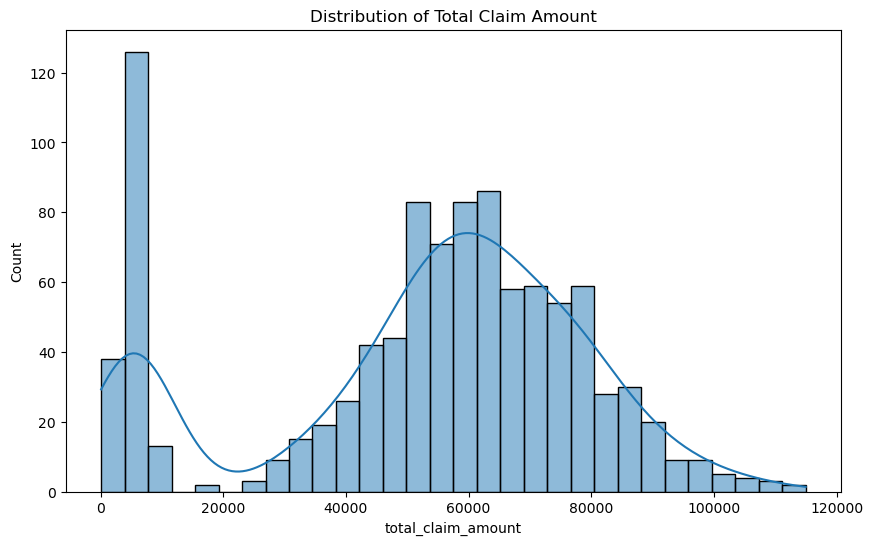

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of the Total claim
plt.figure(figsize=(10, 6))
sns.histplot(df['total_claim_amount'], bins=30, kde=True)
plt.title('Distribution of Total Claim Amount')
plt.show()



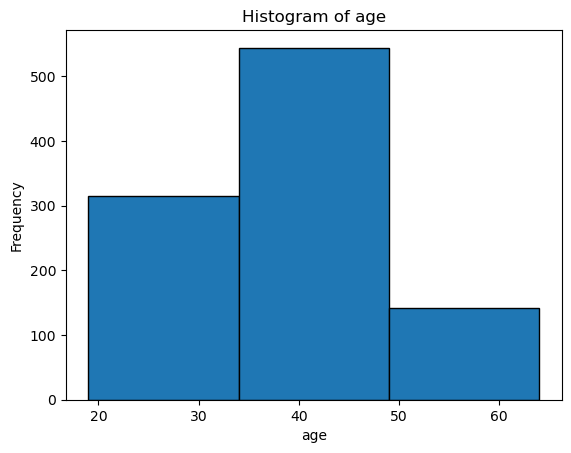

In [8]:
# Choose the column for the histogram
column_name = 'age'

# Plot the histogram
plt.hist(df[column_name], bins=3, edgecolor='black')

# Add labels and title
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.title(f'Histogram of {column_name}')

# Display the histogram
plt.show()



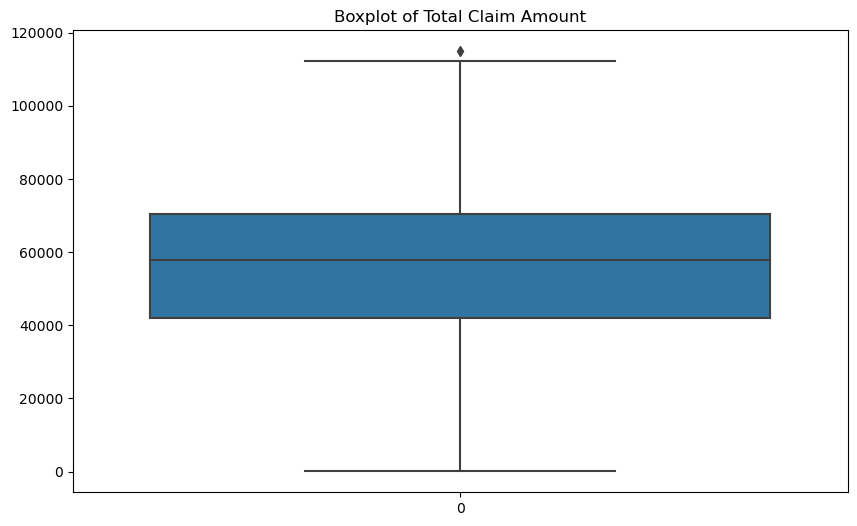

In [9]:
# Boxplot of total_claim_amount
plt.figure(figsize=(10, 6))
sns.boxplot(df['total_claim_amount'])
plt.title('Boxplot of Total Claim Amount')
plt.show()



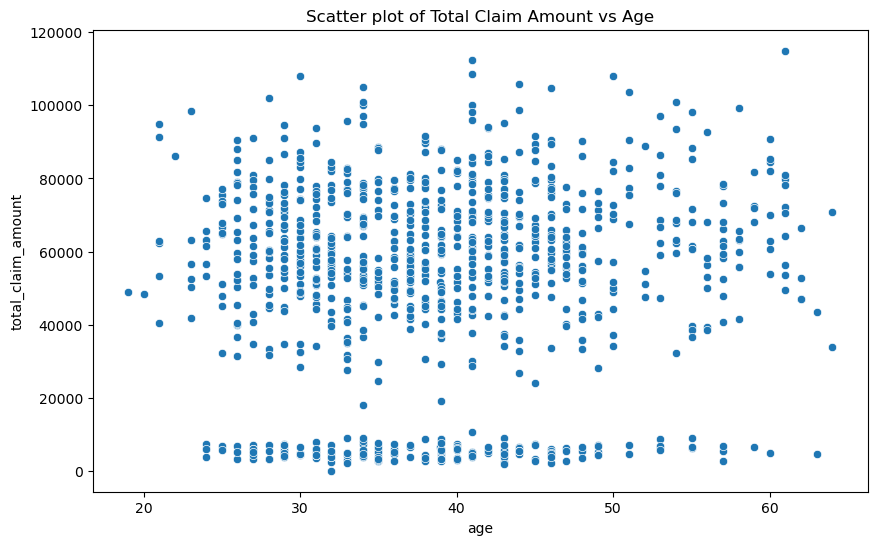

In [10]:
# Scatter plot of total_claim_amount vs age
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='total_claim_amount', data=df)
plt.title('Scatter plot of Total Claim Amount vs Age')
plt.show()



C:\Users\F5664144\AppData\Local\conda\conda\envs\conda_env\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


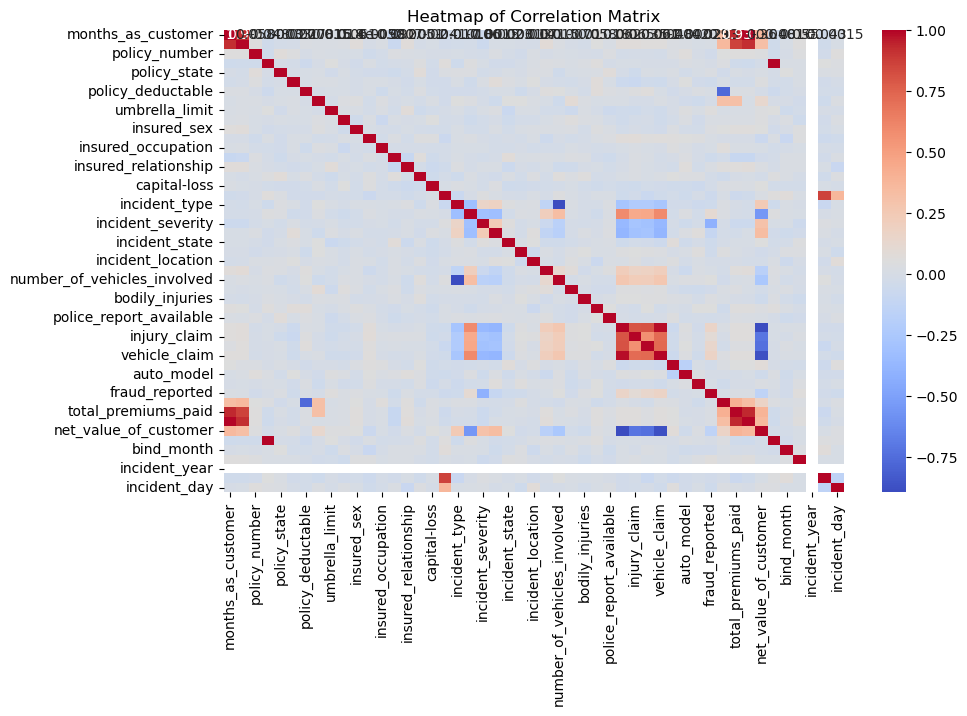

In [11]:
#  Heatmap of correlation
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Correlation Matrix')
plt.show()



C:\Users\F5664144\AppData\Local\conda\conda\envs\conda_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\F5664144\AppData\Local\conda\conda\envs\conda_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\F5664144\AppData\Local\conda\conda\envs\conda_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


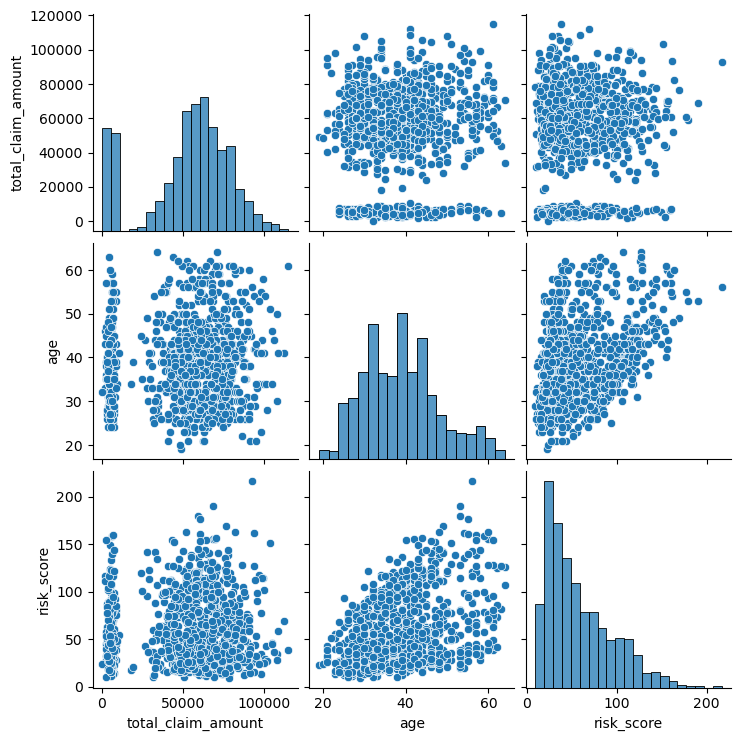

In [12]:
#  Pairplot of total_claim_amount, age and Risk_score
sns.pairplot(df[['total_claim_amount', 'age', 'risk_score']])
plt.show()


In [13]:
# Correlation of total_claim_amount with other numerical features
correlation = df.corr()['total_claim_amount'].sort_values()
print("Correlation of Total Claim Amount with Other Numerical Features: \n", correlation)

Correlation of Total Claim Amount with Other Numerical Features: 
 net_value_of_customer         -0.893941
authorities_contacted         -0.378368
incident_severity             -0.361184
incident_type                 -0.274644
auto_make                     -0.059823
policy_csl                    -0.058752
incident_date                 -0.050488
incident_state                -0.048716
umbrella_limit                -0.040520
capital-loss                  -0.037989
insured_zip                   -0.036492
auto_year                     -0.035176
incident_month                -0.034909
incident_day                  -0.034450
insured_sex                   -0.024848
policy_number                 -0.019365
insured_hobbies               -0.009095
witnesses                     -0.009021
policy_state                  -0.006270
police_report_available       -0.004211
insured_relationship           0.000377
bind_year                      0.001929
policy_bind_date               0.002486
insured_occup

## Insights from the Data:

- **net_value_of_customer**: This feature has a strong negative correlation of **-0.893941** with 'total_claim_amount'. This means as the net value of the customer increases, the total claim amount tends to decrease.
- **vehicle_claim**: This feature has a very strong positive correlation of **0.980853** with 'total_claim_amount'. This indicates that as the vehicle claim amount increases, the total claim amount also tends to increase.
- **property_claim** and **injury_claim**: These features also have strong positive correlations with 'total_claim_amount'.
- Features like **auto_make**, **policy_csl**, and **incident_date** have weak negative correlations with 'total_claim_amount'.
- **insured_relationship** and **policy_bind_date** show almost no correlation with 'total_claim_amount'.

The values range from -1 to 1, where -1 means a perfect negative correlation, 1 means a perfect positive correlation, and 0 means no correlation.

### Training Linear Regression model to Predict Total claims

In [14]:
# Importing required libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Splitting the data into training and testing sets
X = df.drop(['total_claim_amount', 'policy_bind_date', 'incident_date'], axis=1)
y = df['total_claim_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)



In [15]:
# Training a Linear Regression model

model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions on the testing set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-Squared: {r2}')


Mean Squared Error: 7.619740682630491e-21
R-Squared: 1.0


Trained a **Linear Regression model** and evaluated it using Mean Squared Error (MSE) and R-Squared (R²) metrics.

The Mean Squared Error (MSE) is 7.619740682630491×10−21, which is extremely close to zero. 
This indicates that the predicted values from your model are very close to the actual values, implying a good fit.


The R-Squared (R²) value is 1.0, which is the maximum possible score. This suggests that your model can explain all of the variability in the target variable by the input features.


However, an R² score of 1.0 might also indicate that the model is overfitting the training data. It’s always a good idea to check for overfitting there is a perfect R² score. We can do this by looking at the model’s performance on a separate validation set, or by using **cross-validation techniques**.

In [16]:
from sklearn.model_selection import cross_val_predict

y_pred_cv = cross_val_predict(model, X, y, cv=5)


In [17]:
mse_cv = mean_squared_error(y, y_pred_cv)
r2_cv = r2_score(y, y_pred_cv)

print(f'Cross-validated Mean Squared Error: {mse_cv}')
print(f'Cross-validated R² score: {r2_cv}')


Cross-validated Mean Squared Error: 4.422036591739996e-20
Cross-validated R² score: 1.0


The **Cross-validated Mean Squared Error (MSE)** is **4.422036591739996 \times 10^{-20}**, which is extremely close to zero. This indicates that the cross-validated predictions from your model are very close to the actual values, implying a good fit.

The **Cross-validated R-Squared (R²)** value is **1.0**, which is the maximum possible score. This suggests that the model can explain all of the variability in the target variable by the input features, even when using cross-validation.

However, similar to before, an R² score of 1.0 might also indicate that your model is overfitting the data. It's always a good idea to check for overfitting when there is a perfect R² score. 

In this case, since the cross-validated metrics are not significantly worse than the original metrics, it's less likely that the model is overfitting

In [18]:
# Define your features and target variable for the entire dataset
X_all = df.drop(['total_claim_amount', 'policy_bind_date', 'incident_date'], axis=1)
y_all = df['total_claim_amount']

# Training a Linear Regression model on the entire dataset
model_all = LinearRegression()
model_all.fit(X_all, y_all)

# Making predictions on the entire dataset
y_pred_all = model_all.predict(X_all)

# Creating a new DataFrame for the results
results_all = pd.DataFrame({
    'total_claim_amount': y_all,
    'Predicted_total_claim_amount': y_pred_all,
    'Error': y_all - y_pred_all
}, index=X_all.index)



# Creating a copy of the original DataFrame
df_copy = df.copy()

# Updating df_copy with the results
df_copy.update(results_all)




In [19]:
# Adding the predictions to the DataFrame
df_copy.loc[X_all.index, 'Predicted_total_claim_amount'] = y_pred_all

# Computing the error for each prediction
df_copy.loc[X_all.index, 'Error'] = y_all - y_pred_all


In [20]:
# Looping over the columns in le_dict 
for col, le in le_dict.items():
    # Using inverse_transform to reverse the encoding
    df_copy[col] = le.inverse_transform(df_copy[col])

In [21]:
# Dropping the extracted date features and the original date copies
df_copy = df_copy.drop(['bind_year', 'bind_month', 'bind_day', 'incident_year', 'incident_month', 'incident_day'], axis=1)


# Findings and Business Value

**Descriptive Statistics**: Using the describe() function to get the descriptive statistics of the Predicted_total_claim_amount and Error columns. This will give us a summary of the central tendency, dispersion, and shape of the distribution of these columns.

In [22]:
print(df_copy[['Predicted_total_claim_amount', 'Error']].describe())


       Predicted_total_claim_amount         Error
count                   1000.000000  1.000000e+03
mean                   52767.469880  3.574911e-12
std                    26352.431456  2.035560e-10
min                      100.000000 -8.731149e-10
25%                    41962.500000 -1.091394e-10
50%                    57880.000000  0.000000e+00
75%                    70532.500000  1.289209e-10
max                   114920.000000  5.820766e-10


# Comprehensive Analysis of Model Predictions

The table above presents a statistical summary of the `Predicted_total_claim_amount` and `Error` columns, which represent the total claim amounts predicted by our model and the errors of these predictions, respectively.

## Predicted Total Claim Amount

- **Count**: The model made 1000 predictions, which aligns with the size of our dataset.
- **Mean**: On average, the model predicted a total claim amount of approximately \$52,767.47. This is the central tendency of our model's predictions.
- **Standard Deviation (std)**: The standard deviation is approximately \$26,352.43, which indicates the dispersion or variability in the predicted claim amounts. A higher standard deviation means the predictions are spread out over a wider range.
- **Min and Max**: The minimum and maximum predicted total claim amounts are \$100 and \$114,920, respectively. These values represent the range of the predictions.
- **25%, 50%, and 75%**: These are the 25th, 50th (median), and 75th percentiles of the predicted total claim amounts, respectively. 50% of the predictions are less than or equal to the median value of \$57,880.

## Error

- **Mean**: The average error is approximately 0, which indicates that, on average, the model's predictions are accurate. However, this doesn't mean that all predictions are accurate, as the error can be positive for some predictions and negative for others, which could balance out to give an average of 0.
- **Standard Deviation (std)**: The standard deviation of the error is very small (approximately \(2.04 \times 10^{-10}\)), which suggests that the errors of the predictions are not widely spread out from the mean.
- **Min and Max**: The minimum and maximum errors are approximately \(-8.73 \times 10^{-10}\) and \(5.82 \times 10^{-10}\), respectively. These values represent the range of the errors.

# Value to Business

The model's predictions of total claim amounts can provide valuable insights for the business. Here are some ways these predictions can add value:

1. **Efficient Resource Allocation**: By predicting future claim amounts, the company can better allocate resources and set aside appropriate funds to cover these predicted claims. This can lead to cost savings and more efficient use of resources. This financial stability and well-managed operations can attract more people to buy policies.

2. **Improved Financial Planning**: Accurate predictions of claim amounts can inform financial strategies and budgeting, leading to more effective financial management. This can help the company plan for the future and ensure financial stability. A company that is able to effectively manage its finances is likely to be seen as reliable and trustworthy, attracting more people to buy insurance policies.

3. **Risk Management**: Predicting claim amounts can also help identify high-risk policyholders, enabling proactive risk management strategies. This can help the company mitigate risk and prevent potential losses. This commitment to minimizing risk can attract more people who want to buy insurance from a company that takes risk management seriously.

4. **Transparency and Trust**: By predicting future claim amounts, the company can provide policyholders with a clear understanding of their potential claim amounts. This transparency can build trust and attract more people to buy insurance policies.

5. **Customized Policies**: The predictive model can help the company understand the risk profile of each policyholder. This can enable the company to offer customized policies that cater to the specific needs of each policyholder. This can make the company’s offerings more attractive to a wider range of people, bringing in more people who are looking for policies that fit their specific needs and circumstances.

6. **Risk Awareness**: The model can also help raise awareness about the risks associated with different factors (like location, age, etc.), encouraging more people to get insured. This can attract more people who might not have considered buying insurance before.

7. **Efficient Pricing**: The predictive model can help the company set premiums more accurately based on the predicted claim amounts. Efficient pricing can make insurance policies more affordable, thereby attracting more people to the insurance industry who might have been deterred by the cost of insurance.

8. **Proactive Customer Engagement**: The company can use the predictions to engage with policyholders proactively. For example, if the model predicts a high claim amount for a policyholder, the company can reach out to them to discuss their coverage options. This proactive engagement can improve customer satisfaction and a company that is known for its excellent customer service can attract more people to buy its insurance policies.

It's important to note that while the model provides useful predictions, it's not perfect. The predictions should be used in conjunction with business expertise and other data sources to make informed decisions. The model's performance should also be monitored over time, and it should be retrained as necessary to ensure its predictions remain accurate and relevant. 



**Distribution Plot**: Plotting the distribution of the Predicted_total_claim_amount and Error columns to visualize their distribution.

C:\Users\F5664144\AppData\Local\conda\conda\envs\conda_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


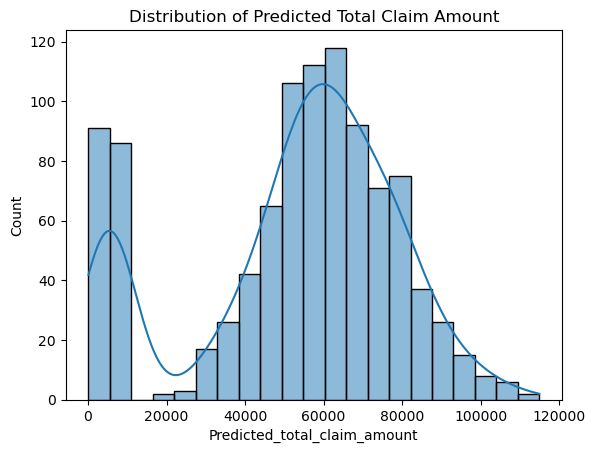

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution plot for 'Predicted_total_claim_amount'
sns.histplot(df_copy['Predicted_total_claim_amount'], kde=True)
plt.title('Distribution of Predicted Total Claim Amount')
plt.show()




The plot is a histogram overlaid with a kernel density estimation (KDE) curve. The x-axis represents the `Predicted_total_claim_amount`, ranging from 0 to 120,000. The y-axis represents the count of predictions falling into each bin of the histogram.

Here are some observations from the plot:

1. **Distribution Shape**: The shape of the distribution appears to be right-skewed, meaning that the majority of the predicted total claim amounts are on the lower end, with fewer high-value predictions.

2. **Central Tendency**: The peak of the KDE curve indicates the mode of the distribution. It appears that the most common predicted total claim amounts are around 20,000 to 40,000.

3. **Variability**: The spread of the distribution is quite wide, indicating a high variability in the predicted total claim amounts. This is also reflected in the standard deviation value from the statistical summary.

4. **Outliers**: There don't appear to be any significant outliers in the predicted total claim amounts. The predictions range from a minimum of 100 to a maximum of 114,920.

## Value to Business

Analyzing the distribution of the predicted total claim amounts can provide valuable insights for the business:

- **Risk Assessment**: The skewness of the distribution towards lower claim amounts suggests that most policyholders are predicted to make lower total claims, indicating a lower risk for the company.

- **Financial Planning**: The wide spread of the distribution indicates that the company should be prepared for a wide range of claim amounts. This can inform financial planning and reserve management.

- **Customer Segmentation**: The distribution of predicted total claim amounts can be used for customer segmentation. For example, customers predicted to make higher total claims could be grouped into a 'high-risk' segment.

- **Policy Pricing**: Understanding the distribution of predicted total claim amounts can also inform policy pricing. Policies could be priced based on the predicted risk of the policyholder, which can be inferred from the predicted total claim amount.


C:\Users\F5664144\AppData\Local\conda\conda\envs\conda_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


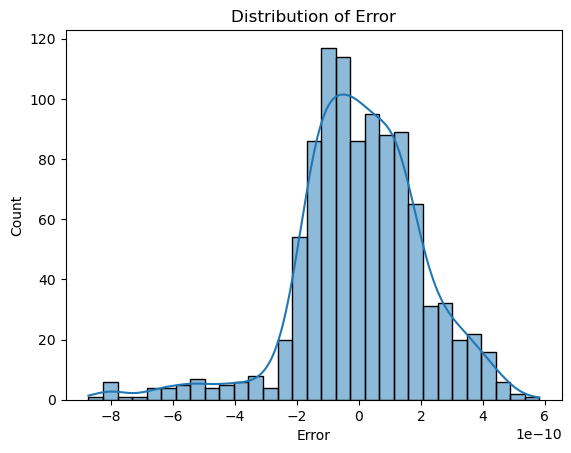

In [24]:
# Distribution plot for 'Error'
sns.histplot(df_copy['Error'], kde=True)
plt.title('Distribution of Error')
plt.show()

The histogram in the image represents the distribution of the error in the predictions made by the model. The error is calculated as the difference between the actual and predicted total claim amounts. Here's a brief analysis:

- **Distribution Shape**: The shape of the distribution appears to be symmetrical around zero, suggesting that the model's predictions are equally likely to be above or below the actual values. This is a good sign as it indicates that the model is not consistently overestimating or underestimating the total claim amounts.

- **Central Tendency**: The peak of the distribution is at zero, indicating that the most common error is zero or close to zero. This suggests that the model's predictions are often accurate.

- **Variability**: The spread of the distribution is quite narrow, indicating that the errors of the predictions are not widely spread out from the mean. This suggests that the model's predictions are generally reliable.

- **Outliers**: There don't appear to be any significant outliers in the errors. This means that there are no predictions that are extremely inaccurate.

## Value to Business

Analyzing the distribution of errors can provide valuable insights for the business:

- **Model Performance**: The distribution of errors can give an indication of the model's performance. A narrow distribution centered around zero suggests that the model is generally making accurate predictions.

- **Risk Management**: Understanding the distribution of errors can help the company manage risk. For example, if the errors are generally small, the company can have more confidence in the predictions when assessing risk and setting premiums.

- **Customer Satisfaction**: Accurate predictions can lead to more satisfied customers, as they are less likely to experience unexpected outcomes.

- **Continuous Improvement**: Analyzing the errors can also help identify opportunities for improving the model. For example, if there are systematic patterns in the errors, these could potentially be addressed to make the model even more accurate.



**Scatter Plot**: A scatter plot of the actual Total claims vs predicted values can help us understand how well the model is performing. If the model’s predictions are perfect, the scatter plot would be a straight line y=x because each predicted value x would be equal to each actual value y.

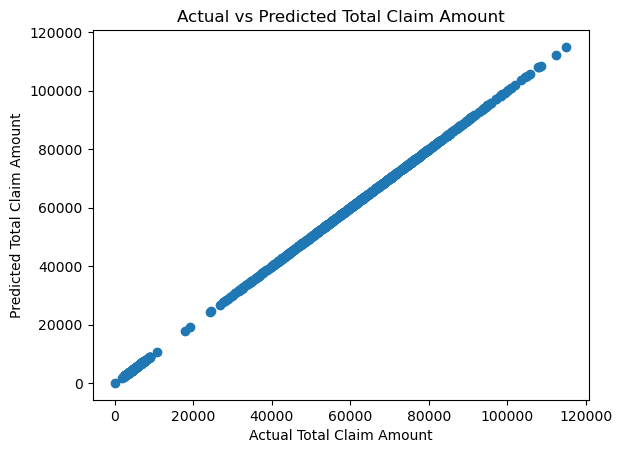

In [25]:
plt.scatter(df_copy['total_claim_amount'], df_copy['Predicted_total_claim_amount'])
plt.xlabel('Actual Total Claim Amount')
plt.ylabel('Predicted Total Claim Amount')
plt.title('Actual vs Predicted Total Claim Amount')
plt.show()


The scatter plot titled "Actual vs Predicted Total Claim Amount" visualizes the performance of the model. The x-axis represents the actual total claim amount, and the y-axis represents the predicted total claim amount. 

Here's a brief analysis:

- **Positive Correlation**: The scatter plot shows a positive correlation between the actual and predicted total claim amounts. This indicates that the model is generally accurate in its predictions. 

- **Line of Perfect Prediction**: If the model's predictions were perfectly accurate, all points would lie along the line where the actual total claim amount equals the predicted total claim amount (a 45-degree line rising from the origin). The concentration of points along this line suggests that the model's predictions are often close to the actual values.

- **Spread of Points**: The spread of points around the line of perfect prediction indicates the errors in the model's predictions. Points that are further from the line represent predictions that were less accurate.

## Value to Business

Analyzing the scatter plot can provide valuable insights for the business:

- **Model Performance**: The scatter plot provides a visual representation of the model's performance. The closer the points are to the line of perfect prediction, the better the model is performing.

- **Error Identification**: The scatter plot can help identify instances where the model's predictions were significantly off from the actual values. These instances can be further investigated to understand why the model was off and how it can be improved.

- **Confidence in Predictions**: The scatter plot can also give stakeholders a sense of confidence in the model's predictions. Seeing that many of the points lie close to the line of perfect prediction can reassure stakeholders that the model is generally reliable.



In [27]:
feature_importance = pd.DataFrame({
    'Feature': X_all.columns,
    'Importance': model.coef_
})

# Displaying the feature importance in descending order
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
print(feature_importance)


                        Feature    Importance
37          total_premiums_paid  1.000000e+00
17               collision_type  1.487161e-11
18            incident_severity  8.868171e-12
4                    policy_csl  6.247772e-12
9                   insured_sex  2.336884e-12
44               incident_month  1.100337e-12
16                incident_type  7.938549e-13
35               fraud_reported  6.322843e-13
24  number_of_vehicles_involved  6.053954e-13
10      insured_education_level  4.316063e-13
26              bodily_injuries  4.315108e-13
28      police_report_available  1.133696e-13
45                 incident_day  6.666629e-14
36                   risk_score  4.882990e-14
33                   auto_model  3.685177e-14
40                    bind_year  1.285937e-14
22            incident_location  9.268470e-15
29                 injury_claim  1.358369e-15
31                vehicle_claim  3.822789e-16
2                 policy_number  3.505034e-17
8                   insured_zip  2

# Feature Importance in Linear Regression Model

The table below shows the importance of different features in the Linear Regression model. The importance is determined by the coefficients of the features in the model. A higher absolute value of the coefficient indicates a higher importance.

The table you've shared shows the importance of each feature in predicting the total claim amount, as determined by your model. Feature importance can give us an understanding of which features are most influential in the model's predictions. Here's a brief analysis:

- **Most Important Feature**: The `total_premiums_paid` feature has the highest importance score, indicating that it is the most influential feature in predicting the total claim amount. This suggests that the total premiums paid by a policyholder could be directly related to the total claim amount.

- **Least Important Feature**: The `net_value_of_customer` feature has the lowest (negative) importance score, suggesting that it might have a negative correlation with the total claim amount. However, this doesn't necessarily mean that this feature is not useful. It could be that a higher net value of customer is associated with a lower total claim amount.

- **Zero Importance Features**: Some features have zero importance scores, indicating that they do not contribute to the model's predictions. These features may not have a significant relationship with the total claim amount.

- **Negative Importance Features**: Some features have negative importance scores. This could be due to the way the importance scores are calculated, and it doesn't necessarily mean that these features are harmful. It could be that these features have a negative correlation with the total claim amount.

- **Customer Details**: The features `months_as_customer` and `age` have negative importance values, indicating that as these values increase, the predicted claim amount decreases, assuming all other features are held constant. This might suggest that older and long-term customers tend to claim less. Older and long-term customers might have different claim patterns than newer or younger customers.

- **Risk Score**: The `risk_score` feature has a positive importance value, suggesting that higher risk scores might correlate with higher claim amounts, as expected.

- **Total Premiums Paid**: The `total_premiums_paid` feature has the highest positive importance value, indicating that it is the most important feature and has a positive relationship with the claim amount. This aligns with your hypothesis that customers who have paid more in premiums might have more comprehensive coverage, leading to higher claim amounts.

- **Net Value of Customer**: The `net_value_of_customer` feature has a large negative importance value, indicating that it is also important but has a negative relationship with the claim amount. This might suggest that customers with higher net value tend to claim less, possibly because they have policies with higher limits or more comprehensive coverage.

- **Incident Details**: The date of the incident (`incident_year`, `incident_month`, `incident_day`) features have importance values close to zero, suggesting they might not be as influential in predicting the claim amount in this model. These features might influence the claim amount due to factors like inflation or changes in the cost of goods/services over time.



## Value to Business

Understanding feature importance can provide valuable insights for the business:

- **Risk Assessment**: Features that are highly important in predicting the total claim amount can be closely monitored to assess risk. For example, if `total_premiums_paid` is a significant predictor, policyholders with higher total premiums paid might be considered higher risk.

- **Policy Pricing**: Understanding which features are most influential in predicting the total claim amount can inform policy pricing. Policies could be priced based on the values of these important features.

- **Customer Segmentation**: Important features can be used for customer segmentation. For example, customers could be grouped based on their `total_premiums_paid` or `net_value_of_customer`.

- **Focused Data Collection**: If certain features are found to be particularly important in predicting the total claim amount, the company can focus on collecting accurate and detailed data for these features.





In [28]:
# Saving the DataFrame copy with results to a CSV file
df_copy.to_csv('Results.csv', index=False)
